<a href="https://colab.research.google.com/github/David-dmh/DL-PBA2/blob/main/DL_PBA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import copy
import os
import time
import random
from random import randint
import shutil
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [183]:
def plot_autoencoder_outputs(autoencoder, x_test, n, dims):
  decoded_imgs = autoencoder.predict(x_test)
  # number of example digits to show
  n = 5
  plt.figure(figsize=(10, 4.5))
  for i in range(n):
      # plot original image
      ax = plt.subplot(2, n, i+1)
      plt.imshow(x_test[i].reshape(*dims))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i==n/2: ax.set_title("Original Images")
      # plot reconstruction image
      ax = plt.subplot(2, n, i+1+n)
      plt.imshow(decoded_imgs[i].reshape(*dims))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n/2: ax.set_title("Reconstructed Images")
  plt.show()

def plot_loss(history):
  historydf = pd.DataFrame(history.history, index=history.epoch)
  plt.figure(figsize=(8, 6))
  historydf.plot(ylim=(0, historydf.values.max()))
  plt.title("Loss: %.3f" % history.history["loss"][-1])

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
  dflist = []
  min_epoch = len(history_list[0].epoch)
  losses = []
  for history in history_list:
      h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
      dflist.append(pd.DataFrame(h, index=history.epoch))
      min_epoch = min(min_epoch, len(history.epoch))
      losses.append(h["loss"][-1])

  historydf = pd.concat(dflist, axis=1)
  metrics = dflist[0].columns
  idx = pd.MultiIndex.from_product([name_list, metrics], names=["model", "metric"])
  historydf.columns = idx
  plt.figure(figsize=(6, 8))
  ax = plt.subplot(211)
  historydf.xs("loss", axis=1, level="metric").plot(ylim=(0, 1), ax=ax)
  plt.title("Training Loss: " + " vs ".join([str(round(x, 3)) for x in losses]))
  if plot_accuracy:
      ax = plt.subplot(212)
      historydf.xs("acc", axis=1, level="metric").plot(ylim=(0, 1), ax=ax)
      plt.title("Accuracy")
      plt.xlabel("Epochs")

  plt.xlim(0, min_epoch-1)
  plt.tight_layout()

def preprocess(array):
  """
  Reshape array.
  """
  array = np.reshape(array, (len(array), 28, 28, 1))

  return array

def noise(array):
  """
  Add random noise to each image in array.
  """
  noise_factor = 0.4
  noisy_array = array + noise_factor*np.random.normal(loc=0.0, 
                                                        scale=1.0, 
                                                        size=array.shape)

  return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2, x, y, z, size=5):
  """
  Display n random images from each supplied array.
  """
  n = 5
  indices = np.random.randint(len(array1), size=size)
  images1 = array1[indices, :]
  images2 = array2[indices, :]
  plt.figure(figsize=(20, 4))
  for i, (image1, image2) in enumerate(zip(images1, images2)):
      ax = plt.subplot(2, n, i+1)
      if z == 1: plt.imshow(image1.reshape(x, y))
      else: plt.imshow(image1.reshape(x, y, z))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(2, n, i+1+n)
      if z == 1: plt.imshow(image2.reshape(x, y))
      else: plt.imshow(image2.reshape(x, y, z))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

# SGD and Mini Batch 

In [184]:
X_train = pd.read_csv(
    "https://res.cloudinary.com/dd6valcsx/raw/upload/v1626877483/datasets/DL%20874/PB2/trainX_x9dbnk.csv", 
    header=None
    ).values
y_train = pd.read_csv(
    "https://res.cloudinary.com/dd6valcsx/raw/upload/v1626877482/datasets/DL%20874/PB2/trainy_kxg5sz.csv", 
    header=None
    ).values
X_test = pd.read_csv(
    "https://res.cloudinary.com/dd6valcsx/raw/upload/v1626968310/datasets/DL%20874/PB2/testX_gtchbx.csv", 
    header=None
    ).values
y_test = pd.read_csv(
    "https://res.cloudinary.com/dd6valcsx/raw/upload/v1626968310/datasets/DL%20874/PB2/testy_ahwlsm.csv", 
    header=None
    ).values

In [185]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 1) (800, 1) (200, 1) (200, 1)


In [186]:
print(X_train[:5])
print(y_train[:5])

[[1.03727217]
 [0.87205884]
 [0.78176127]
 [1.22701361]
 [0.35667595]]
[[7.88278069]
 [7.54363375]
 [6.00373075]
 [9.22724112]
 [4.25371083]]


## 2 - i.

### Use for SGB or MBGD

In [187]:
class linreg_opt_algo:
  def create_batch(self, x_train, y_train, batch_size):
      mini_batches = []
      data = np.stack((x_train, y_train), axis=1)
      np.random.shuffle(data)
      no_of_batches = x_train.shape[0] // batch_size
      for i in range(no_of_batches):
          mini_batch = data[i*batch_size: (i + 1)*batch_size]
          mini_batches.append((mini_batch[:, 0], mini_batch[:, 1]))
      if x_train.shape[0] % batch_size != 0:
          mini_batch = data[(i + 1)*batch_size:]
          mini_batches.append((mini_batch[:, 0], mini_batch[:, 1]))

      return mini_batches
  
  def fit(self, x_train, y_train, lr, epochs, batch_size):
    # capture loss over time
    mses = []
    # random init m, c
    self.m = np.random.randn(1, 1) 
    self.c = np.random.randn(1, 1)
    l = len(x_train)
    for i in range(epochs):
        batches = self.create_batch(x_train, y_train, batch_size)
        for batch in batches:
            xb = batch[0]
            yb = batch[1]
            yb_c = copy.deepcopy(yb)
            xb = xb.reshape(1, xb.shape[0])
            intercept = np.sum((np.dot(self.m, xb) + self.c) - yb)
            slope = np.sum(((np.dot(self.m, xb) + self.c) - yb)*xb)
            actual = yb_c
            pred = (np.dot(self.m, xb) + intercept).reshape(batch_size, 1)
            mymse = np.mean((pred - actual)**2)
            mses.append(mymse)
            self.m = self.m - lr*(slope / l)
            self.c = self.c - lr*(intercept / l)

    plt.plot(range(len(mses)), [*mses])
    plt.xlabel("Update number")
    plt.ylabel("MSE")
    plt.title("MSE change per parameter update")
  
  def slope_intercept(self):
    m = self.m[0][0];
    c = self.c[0][0];
    print("Slope (m):", m)
    print("Intercept (c):", c)

    return m, c

  def predict(self, x_test):
    x_test = x_test.reshape(x_test.shape[0], 1)
    self.m = self.m.reshape(self.m.shape[1], self.m.shape[0])
    result = np.dot(x_test, self.m) + self.c
    
    return result

### Stochastic Gradient Descent:

Slope (m): 0.9909927125485877
Intercept (c): -0.04976310135461264


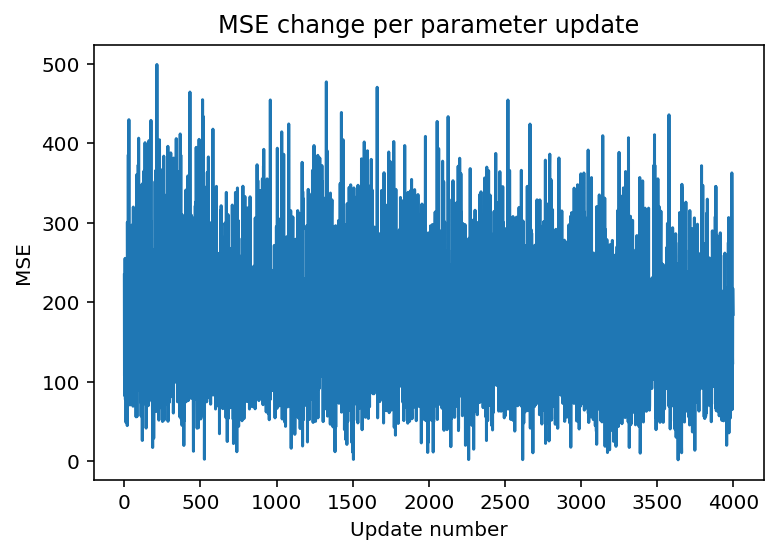

In [188]:
sgd = linreg_opt_algo() 
# batch size of 1 for SGD
sgd.fit(X_train, y_train, lr=0.01, epochs=5, batch_size=1)
sgd.slope_intercept();

### Mini Batch:

Slope (m): 3.0585334172036793
Intercept (c): 3.251388285403904


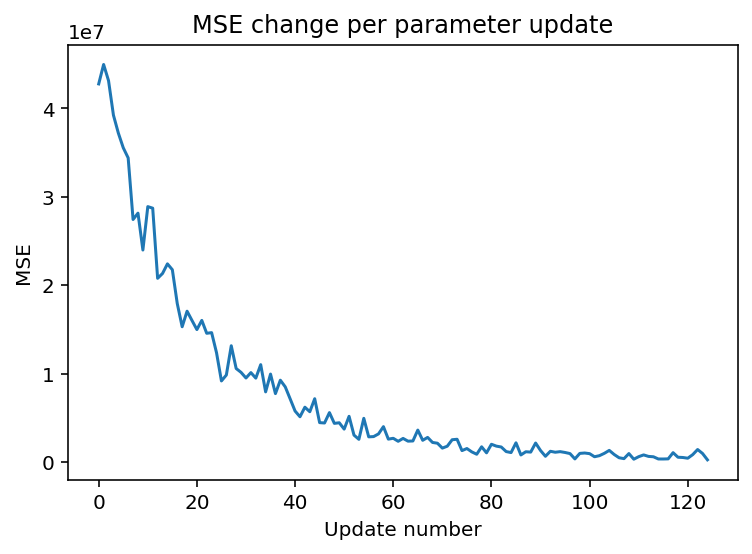

In [189]:
mbgd = linreg_opt_algo() 
# batch size of (1 < batch size < # datapoints) for MBGD
mbgd.fit(X_train, y_train, lr=0.01, epochs=5, batch_size=32) 
mbgd.slope_intercept();

## 2 - ii.

In [69]:
model = keras.Sequential([layers.Dense(512, activation="relu", input_shape=[1]), 
                          layers.Dense(512, activation="relu"), 
                          layers.Dense(512, activation="relu"), 
                          layers.Dense(512, activation="relu"), 
                          layers.Dense(512, activation="relu"), 
                          layers.Dense(1)])
model.compile(optimizer="adam", 
              loss="mse", 
              metrics=["mse"])
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=500, 
                    callbacks=[early_stopping])

Epoch 1/500
25/25 [==============================] - 1s 22ms/step - loss: 14.8016 - mse: 14.8016 - val_loss: 2.5870 - val_mse: 2.5870
Epoch 2/500
25/25 [==============================] - 0s 17ms/step - loss: 2.1791 - mse: 2.1791 - val_loss: 1.1137 - val_mse: 1.1137
Epoch 3/500
25/25 [==============================] - 0s 17ms/step - loss: 1.3547 - mse: 1.3547 - val_loss: 0.8372 - val_mse: 0.8372
Epoch 4/500
25/25 [==============================] - 0s 16ms/step - loss: 1.0764 - mse: 1.0764 - val_loss: 0.7929 - val_mse: 0.7929
Epoch 5/500
25/25 [==============================] - 0s 19ms/step - loss: 1.0902 - mse: 1.0902 - val_loss: 0.8022 - val_mse: 0.8022
Epoch 6/500
25/25 [==============================] - 0s 15ms/step - loss: 1.0703 - mse: 1.0703 - val_loss: 0.8180 - val_mse: 0.8180
Epoch 7/500
25/25 [==============================] - 0s 17ms/step - loss: 1.1134 - mse: 1.1134 - val_loss: 0.8000 - val_mse: 0.8000
Epoch 8/500
25/25 [==============================] - 0s 15ms/step - loss: 

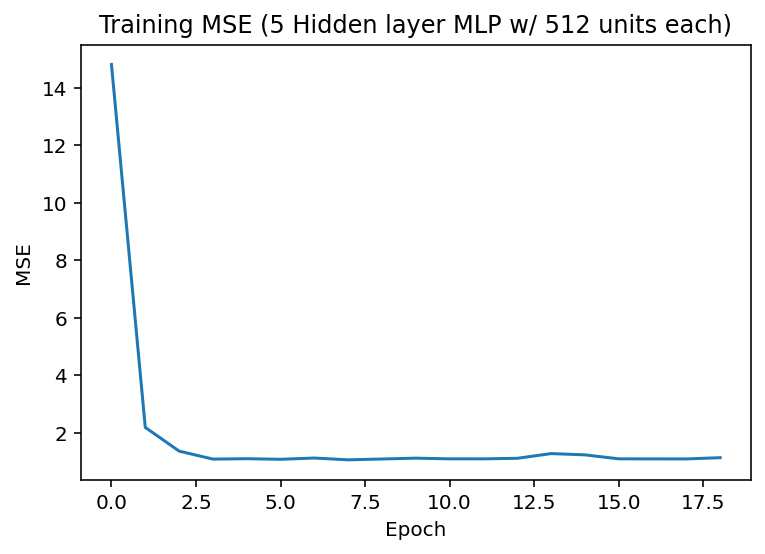

In [70]:
# plot
plt.plot(history.history["mse"])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training MSE (5 Hidden layer MLP w/ 512 units each)")
plt.show()

## 2 - iii.

In [190]:
# SGD evaluation
y_pred = sgd.predict(X_test)
print(mean_squared_error(y_test, y_pred))

37.845615544976276


In [191]:
# MBGD evaluation
y_pred = mbgd.predict(X_test)
print(mean_squared_error(y_test, y_pred))

1.3136706670128009


In [73]:
# MLP evaluation
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.7929 - mse: 0.7929


[0.7929062843322754, 0.7929062843322754]

# Autoencoders and CNN

## 1 - i.

In [163]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({"id": "1hCDxOe93jRjr9VUywd6j4Fn2UhV_EJSe"})
download.GetContentFile("x_train_images.csv")
x_train_images = pd.read_csv("x_train_images.csv", header=None).values.reshape(60000, 28, 28)
print(x_train_images.shape)

(60000, 28, 28)


In [164]:
download = drive.CreateFile({"id": "1M_nyP5KRuw1MuLO18cxruky7_WQJIuJj"})
download.GetContentFile("x_test_images.csv")
x_test_images = pd.read_csv("x_test_images.csv", header=None).values.reshape(10000, 28, 28)
print(x_test_images.shape)

(10000, 28, 28)


## 1 - iii.

In [165]:
x_train_images = copy.deepcopy(x_train_images).reshape(60000, 784)
x_test_images = copy.deepcopy(x_test_images).reshape(10000, 784)
x_train_images.shape, x_test_images.shape

((60000, 784), (10000, 784))

### a. Undercomplete/shallow autoencoder

#### Model:

In [25]:
uc_autoencoder = models.Sequential([layers.InputLayer(input_shape=784),
                                    layers.Dense(32, activation="relu"),
                                    layers.Dense(784, activation="sigmoid")])
uc_autoencoder.compile(optimizer="adam", 
                       metrics=["mse"], 
                       loss="binary_crossentropy")
history = uc_autoencoder.fit(x_train_images, x_train_images, 
                             validation_data=(x_test_images, x_test_images), 
                             epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1614 - mse: 0.0319 - val_loss: 0.1124 - val_mse: 0.0159
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1040 - mse: 0.0132 - val_loss: 0.0966 - val_mse: 0.0111
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0964 - mse: 0.0110 - val_loss: 0.0941 - val_mse: 0.0104
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0950 - mse: 0.0106 - val_loss: 0.0933 - val_mse: 0.0102
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0945 - mse: 0.0105 - val_loss: 0.0930 - val_mse: 0.0101
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0942 - mse: 0.0104 - val_loss: 0.0927 - val_mse: 0.0100
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0940 - mse: 0.0103 - val_loss: 0.0925 - val_mse: 0.0099
Epoch 8/10
1875/1875 [==============================] - 6s 3ms

#### Metrics:

In [26]:
print(np.mean(uc_autoencoder.predict(x_test_images)))

0.13425821


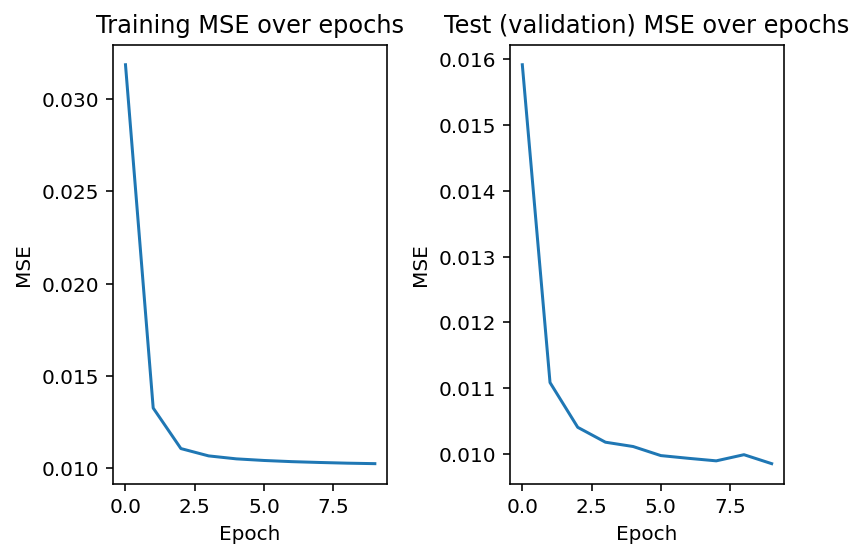

In [27]:
metrics = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2)
metrics["mse"].plot(ax=ax[0], 
                    title="Training MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
metrics["val_mse"].plot(ax=ax[1], 
                    title="Test (validation) MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
fig.tight_layout()

#### Plot:

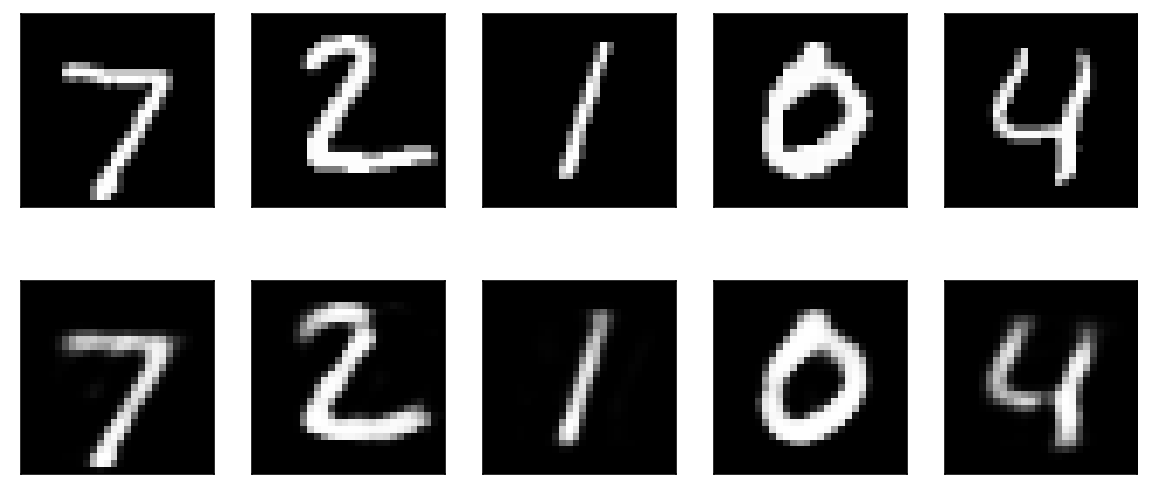

In [28]:
plot_autoencoder_outputs(uc_autoencoder, x_test_images, 5, (28, 28))

### b. Stacked autoencoder

#### Model:

In [31]:
st_autoencoder = models.Sequential([layers.InputLayer(input_shape=784),
                                    layers.Dense(128, activation="relu"),
                                    layers.Dense(32, activation="relu"),
                                    layers.Dense(128, activation="relu"),
                                    layers.Dense(784, activation="sigmoid")])
st_autoencoder.compile(optimizer="adam", 
                       metrics=["mse"], 
                       loss="binary_crossentropy")
history = st_autoencoder.fit(x_train_images, x_train_images,
                             validation_data=(x_test_images, x_test_images), 
                             epochs=5)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1389 - mse: 0.0251 - val_loss: 0.1020 - val_mse: 0.0131
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0986 - mse: 0.0119 - val_loss: 0.0936 - val_mse: 0.0104
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0933 - mse: 0.0103 - val_loss: 0.0906 - val_mse: 0.0095
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0905 - mse: 0.0094 - val_loss: 0.0882 - val_mse: 0.0087
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0887 - mse: 0.0088 - val_loss: 0.0869 - val_mse: 0.0083


#### Metrics:

In [32]:
print(np.mean(st_autoencoder.predict(x_test_images)))

0.1339372


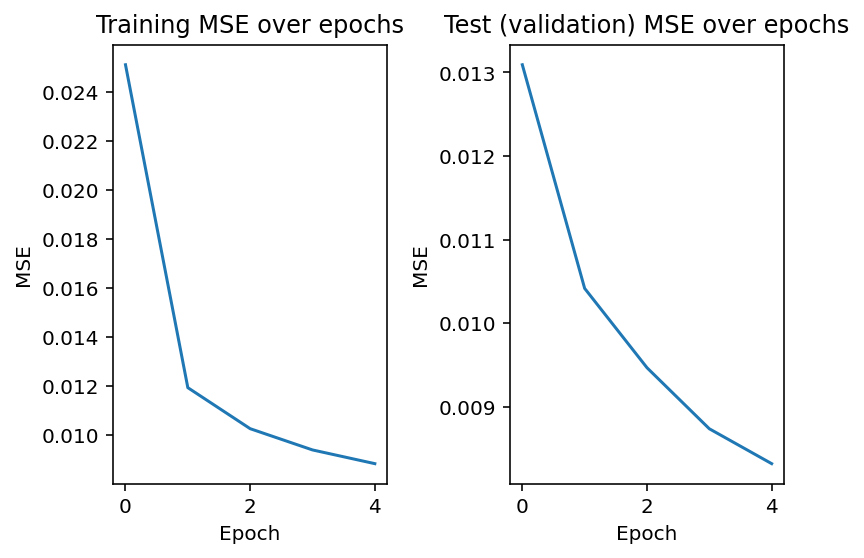

In [33]:
metrics = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2)
metrics["mse"].plot(ax=ax[0], 
                    title="Training MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
metrics["val_mse"].plot(ax=ax[1], 
                    title="Test (validation) MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
fig.tight_layout()

#### Plot:

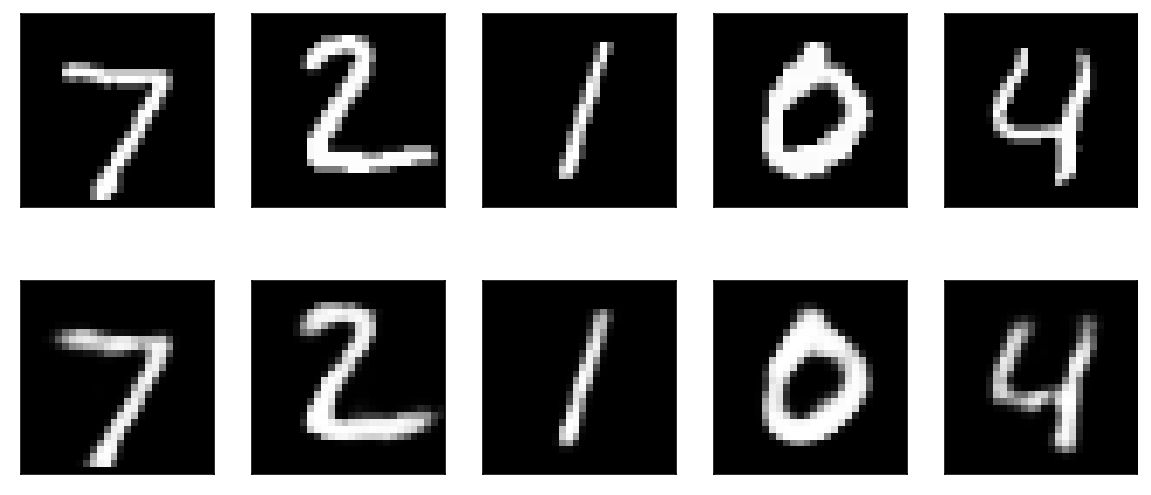

In [34]:
plot_autoencoder_outputs(st_autoencoder, x_test_images, 5, (28, 28))

### c. Sparse autoencoder

#### Model:

In [170]:
sp_autoencoder_reg = models.Sequential([layers.InputLayer(input_shape=784),
                                        layers.Dense(32, 
                                                    activity_regularizer=l1(10e-6), 
                                                    activation="relu"),
                                        layers.Dense(784, activation="sigmoid")])
sp_autoencoder_reg.compile(optimizer="adam", 
                           metrics=["mse"],
                           loss="binary_crossentropy")
history_reg = sp_autoencoder_reg.fit(x_train_images, x_train_images, 
                                     validation_data=(x_test_images, x_test_images),
                                     epochs=20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1619 - mse: 0.0315 - val_loss: 0.1143 - val_mse: 0.0159
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1055 - mse: 0.0131 - val_loss: 0.0985 - val_mse: 0.0110
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0984 - mse: 0.0110 - val_loss: 0.0961 - val_mse: 0.0104
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0972 - mse: 0.0107 - val_loss: 0.0954 - val_mse: 0.0102
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0965 - mse: 0.0105 - val_loss: 0.0950 - val_mse: 0.0101
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0961 - mse: 0.0104 - val_loss: 0.0947 - val_mse: 0.0100
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0958 - mse: 0.0103 - val_loss: 0.0945 - val_mse: 0.0099
Epoch 8/20
1875/1875 [==============================] - 6s 3ms

#### Metrics:

In [171]:
print(np.mean(sp_autoencoder_reg.predict(x_test_images)))

0.1327673


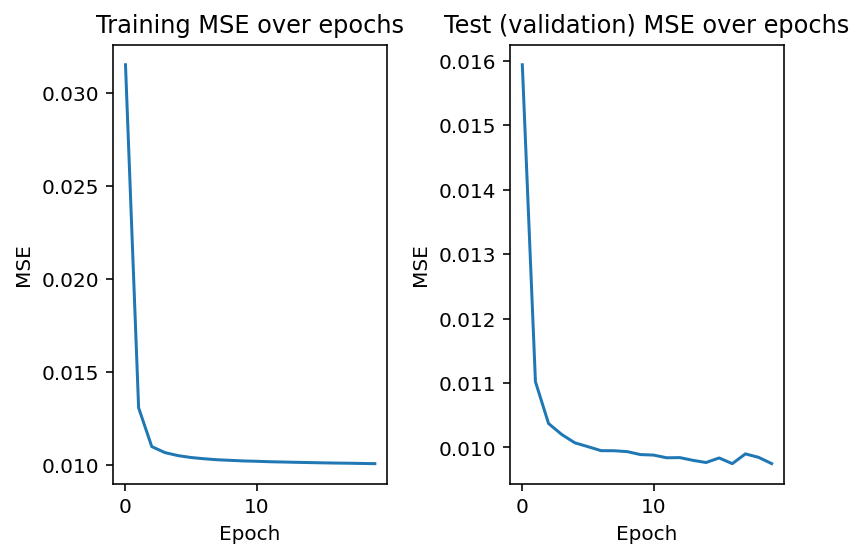

In [172]:
metrics = pd.DataFrame(history_reg.history)
fig, ax = plt.subplots(1, 2)
metrics["mse"].plot(ax=ax[0], 
                    title="Training MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
metrics["val_mse"].plot(ax=ax[1], 
                    title="Test (validation) MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
fig.tight_layout()

#### Plot:

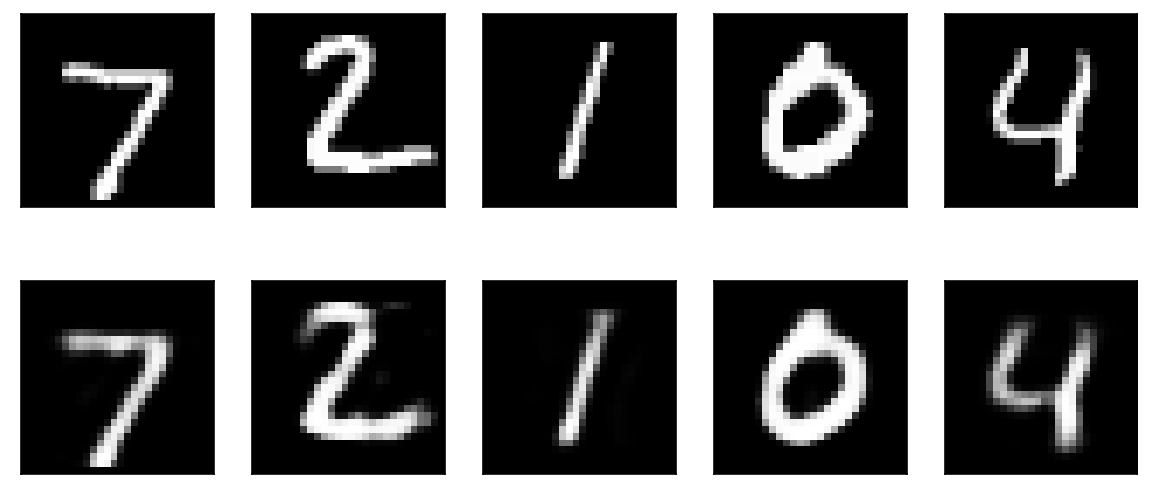

In [173]:
plot_autoencoder_outputs(sp_autoencoder_reg, x_test_images, 5, (28, 28))

### d. Denoising autoencoder

#### Model:

In [ ]:
noise_factor = 0.4
x_train_noisy = x_train_images + noise_factor*np.random.normal(size=x_train_images.shape) 
x_test_noisy = x_test_images + noise_factor*np.random.normal(size=x_test_images.shape)
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# n = 5
# plt.figure(figsize=(10, 4.5))
# for i in range(n):
#     # original
#     ax = plt.subplot(2, n, i+1)
#     plt.imshow(x_test_images[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # noisy 
#     ax = plt.subplot(2, n, i+1+n)
#     plt.imshow(x_test_noisy[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

In [42]:
dn_autoencoder = models.Sequential([layers.InputLayer(input_shape=784),
                                    layers.Dense(128, activation="relu"),
                                    layers.Dense(32, activation="relu"),
                                    layers.Dense(128, activation="relu"),
                                    layers.Dense(784, activation="sigmoid")])
dn_autoencoder.compile(optimizer="adam", 
                       metrics=["mse"], 
                       loss="binary_crossentropy")
history = dn_autoencoder.fit(x_train_noisy, x_train_images,
                             validation_data=(x_test_noisy, x_test_images), 
                             epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1675 - mse: 0.0346 - val_loss: 0.1366 - val_mse: 0.0244
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1320 - mse: 0.0228 - val_loss: 0.1269 - val_mse: 0.0211
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1252 - mse: 0.0206 - val_loss: 0.1226 - val_mse: 0.0198
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1220 - mse: 0.0195 - val_loss: 0.1207 - val_mse: 0.0192
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1198 - mse: 0.0188 - val_loss: 0.1182 - val_mse: 0.0184
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1182 - mse: 0.0183 - val_loss: 0.1172 - val_mse: 0.0180
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1167 - mse: 0.0178 - val_loss: 0.1155 - val_mse: 0.0175
Epoch 8/10
1875/1875 [==============================] - 

#### Metrics:

In [43]:
print(np.mean(dn_autoencoder.predict(x_test_noisy))) # preds for noisy

0.1293294


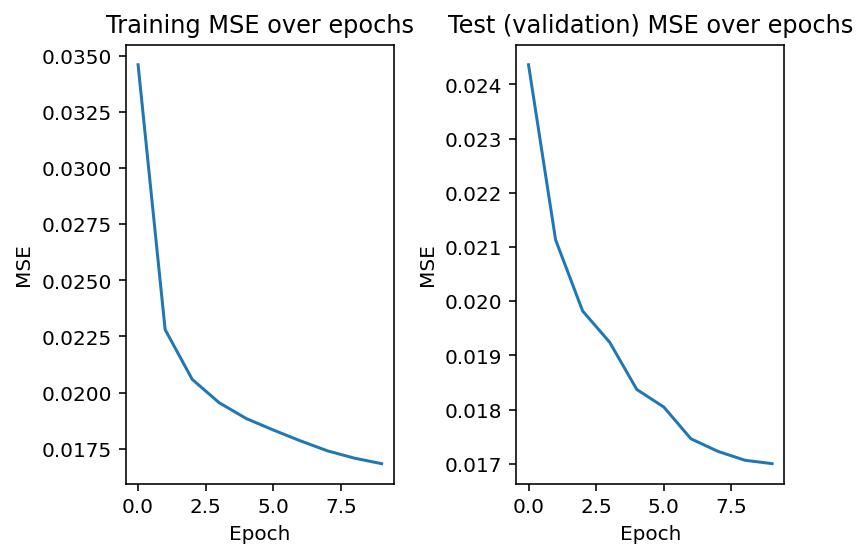

In [44]:
metrics = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2)
metrics["mse"].plot(ax=ax[0], 
                    title="Training MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
metrics["val_mse"].plot(ax=ax[1], 
                    title="Test (validation) MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
fig.tight_layout()

#### Plot:

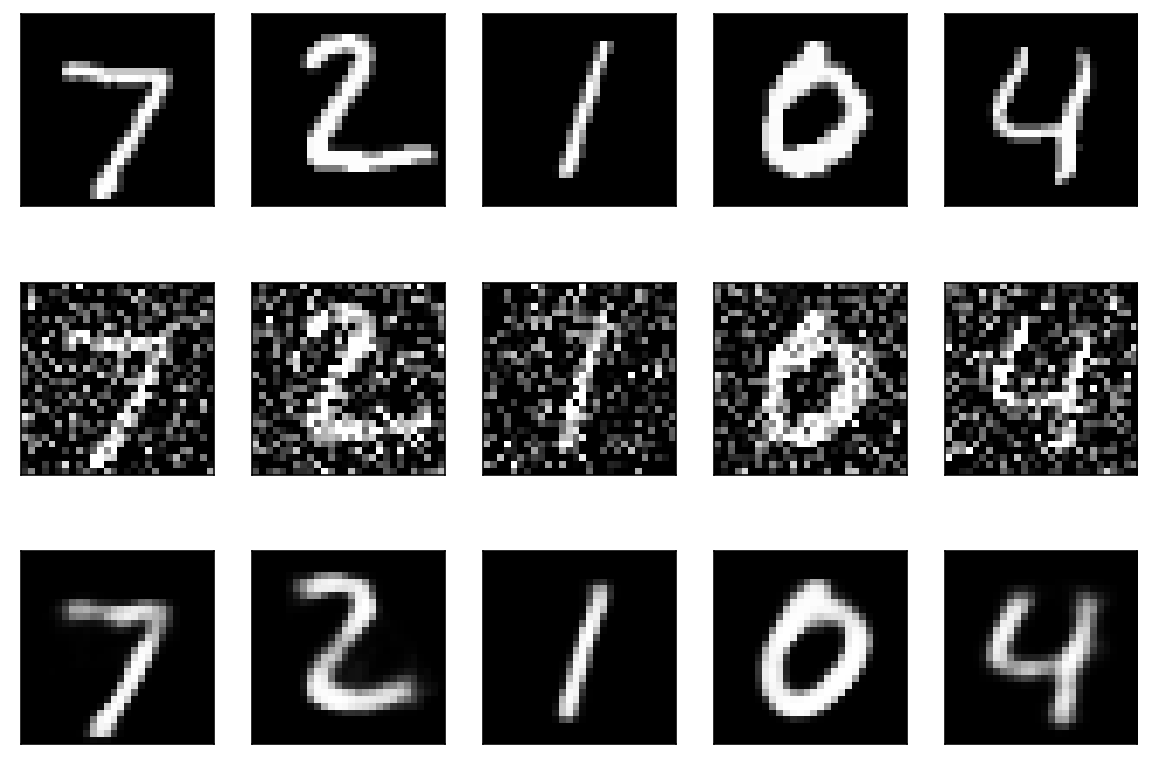

In [46]:
n = 5
plt.figure(figsize=(10, 7))
images = dn_autoencoder.predict(x_test_noisy)

for i in range(n):
    # original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # noisy 
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # denoised 
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### e. Convolutional autoencoder

#### Model:

In [93]:
x_train_images.shape, x_test_images.shape

((60000, 784), (10000, 784))

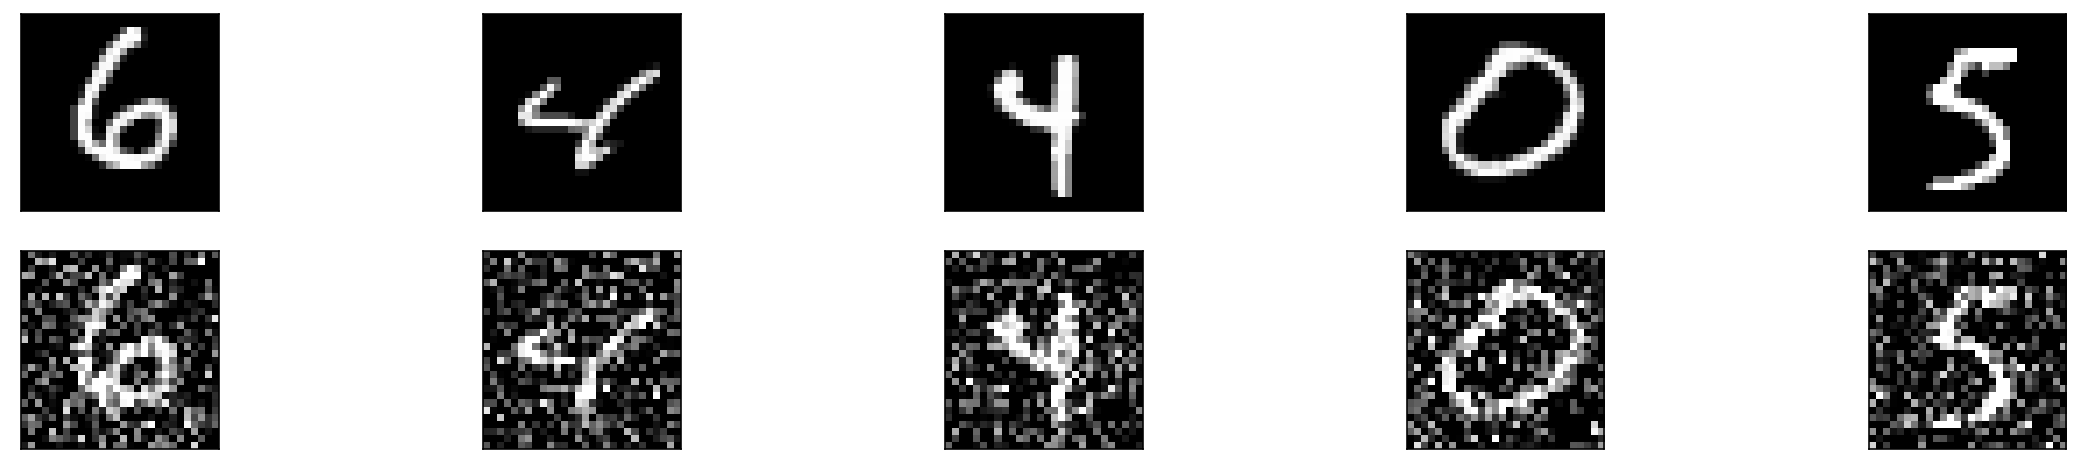

In [125]:
x_train_images_noisy = noise(x_train_images)
x_test_images_noisy = noise(x_test_images)
display(x_train_images, x_train_images_noisy, x=28, y=28, z=1)

In [120]:
e_x_train_images = tf.convert_to_tensor(x_train_images.reshape)
e_x_test_images = tf.convert_to_tensor(x_test_images)
e_x_train_images_noisy = tf.convert_to_tensor(noise(x_train_images))
e_x_test_images_noisy = tf.convert_to_tensor(noise(x_test_images))

In [129]:
encoder = models.Sequential([layers.InputLayer(input_shape=(28, 28, 1)),
                             layers.Conv2D(32, (3, 3), 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"),
                             layers.MaxPooling2D((2, 2), strides=2), 
                             layers.Conv2D(32, (3, 3), 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D((2, 2), strides=2)])
decoder = models.Sequential([layers.Conv2DTranspose(32, (3, 3), 
                                                    strides=2, 
                                                    padding="same", 
                                                    activation="relu", 
                                                    input_shape=encoder.output.shape[1:]),
                             layers.Conv2DTranspose(32, (3, 3), 
                                                    strides=2, 
                                                    padding="same", 
                                                    activation="relu"),
                             layers.Conv2D(1, (3, 3), 
                                           strides=1, 
                                           padding="same", 
                                           activation="sigmoid")])
conv_autoencoder = keras.models.Model(inputs=encoder.input, 
                                      outputs=decoder(encoder.outputs))
conv_autoencoder.compile(optimizer="adam", 
                         metrics=["mse"], 
                         loss="binary_crossentropy")
# history = conv_autoencoder.fit(e_x_train_images, e_x_train_images, 
#                                validation_data=(e_x_test_images, e_x_test_images),
#                                batch_size=128,
#                                shuffle=True, 
#                                epochs=10)
history = conv_autoencoder.fit(x_train_images_noisy, x_train_images, 
                               validation_data=(x_test_images_noisy, x_test_images),
                               batch_size=128,
                               shuffle=True, 
                               epochs=10)

Epoch 1/10
469/469 [==============================] - 154s 328ms/step - loss: 0.1763 - mse: 0.0371 - val_loss: 0.1071 - val_mse: 0.0145
Epoch 2/10
469/469 [==============================] - 153s 327ms/step - loss: 0.1029 - mse: 0.0131 - val_loss: 0.0983 - val_mse: 0.0117
Epoch 3/10
469/469 [==============================] - 153s 326ms/step - loss: 0.0976 - mse: 0.0114 - val_loss: 0.0950 - val_mse: 0.0107
Epoch 4/10
469/469 [==============================] - 155s 331ms/step - loss: 0.0951 - mse: 0.0106 - val_loss: 0.0935 - val_mse: 0.0102
Epoch 5/10
469/469 [==============================] - 153s 326ms/step - loss: 0.0935 - mse: 0.0101 - val_loss: 0.0920 - val_mse: 0.0097
Epoch 6/10
469/469 [==============================] - 153s 327ms/step - loss: 0.0922 - mse: 0.0097 - val_loss: 0.0909 - val_mse: 0.0094
Epoch 7/10
469/469 [==============================] - 153s 326ms/step - loss: 0.0912 - mse: 0.0094 - val_loss: 0.0900 - val_mse: 0.0091
Epoch 8/10
469/469 [============================

#### Metrics:

In [130]:
print(np.mean(conv_autoencoder.predict(x_test_images_noisy))) # preds for noisy

0.13151594


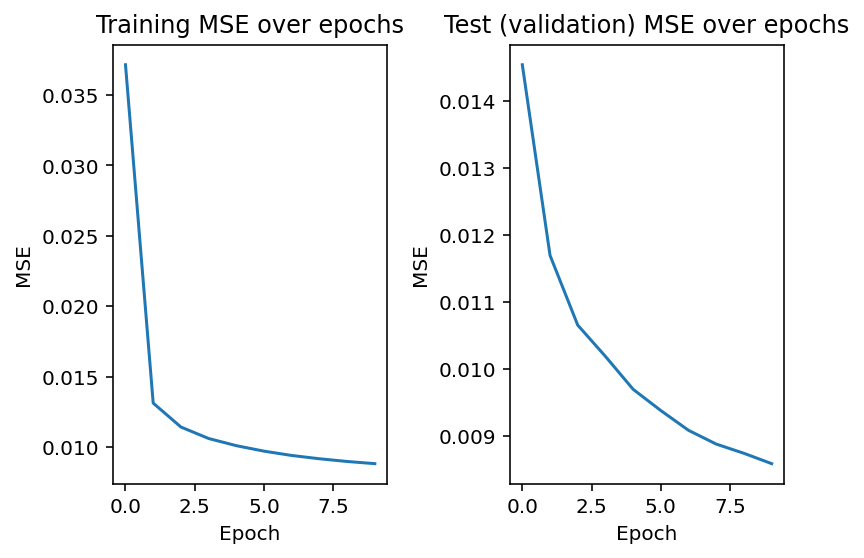

In [131]:
metrics = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2)
metrics["mse"].plot(ax=ax[0], 
                    title="Training MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
metrics["val_mse"].plot(ax=ax[1], 
                    title="Test (validation) MSE over epochs", 
                    xlabel="Epoch", 
                    ylabel="MSE");
fig.tight_layout()

#### Plot:

In [132]:
# predictions = conv_autoencoder.predict(e_x_test_images)
# display(e_x_test_images, predictions, x=28, y=28, z=1)

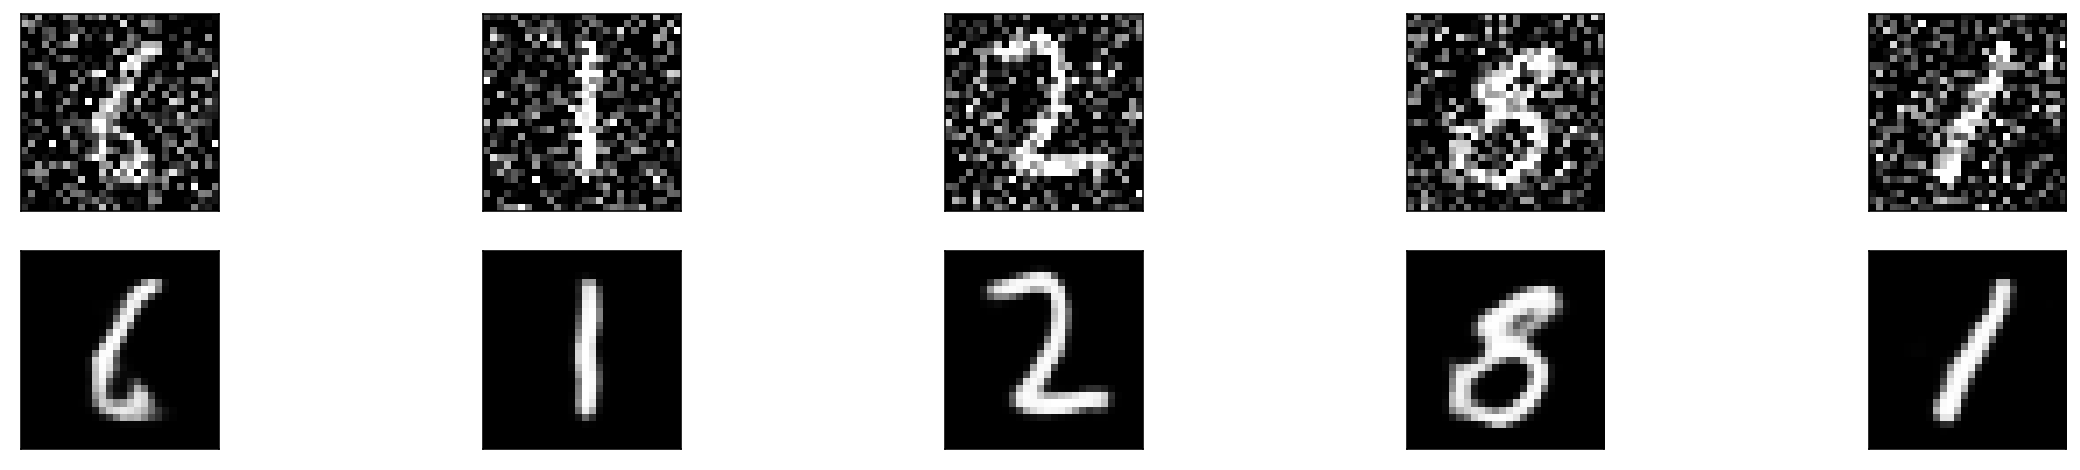

In [133]:
predictions = conv_autoencoder.predict(x_test_images_noisy)
display(x_test_images_noisy, predictions, x=28, y=28, z=1)

## 2 - i.

In [134]:
working_path = "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/"

In [135]:
## data = os.listdir("/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/Dogs/")

## from sklearn.model_selection import train_test_split
## train, valid = train_test_split(data, test_size=0.2, random_state=1)

## all_img_rootdir = "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/Dogs/"
## destination = "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/train/"
## for filename in train:
##   shutil.move(all_img_rootdir+filename, destination)

# !ls "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/train/"

In [136]:
## destination2 = "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/valid/"
## for filename in valid:
##   shutil.move(all_img_rootdir+filename, destination2)

# !ls "/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/valid/"

In [137]:
# train_datagen = ImageDataGenerator()
# val_datagen = ImageDataGenerator()
# train_gen = train_datagen.flow_from_directory(working_path, 
#                                               classes=["train"], 
#                                               batch_size=32, 
#                                               target_size=(64, 64))
# val_gen = val_datagen.flow_from_directory(working_path, 
#                                           classes=["valid"],
#                                           batch_size=32,
#                                           target_size=(64, 64))

Found 320 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


In [138]:
files = []
for root, _, filenames in os.walk("/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/train"):
  for filename in filenames:
    files.append(os.path.join(root, filename))

x_train = []
for f in files:
  x_train.append(plt.imread(f))

files = []
for root, _, filenames in os.walk("/content/drive/MyDrive/! *SHARED DOCS* !/Deep Learning 874/PB2/valid"):
  for filename in filenames:
    files.append(os.path.join(root, filename))

x_test = []
for f in files:
  x_test.append(plt.imread(f))
  
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

## 2 - ii.

### Base model

In [ ]:
encoder = models.Sequential([layers.Conv2D(64, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=x_train.shape[1:]),
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(64, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2)])
decoder = models.Sequential([layers.Conv2D(32, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=encoder.output.shape[1:]),
                            layers.UpSampling2D(2),
                            layers.Conv2D(64, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"),
                            layers.UpSampling2D(2),
                            layers.Conv2D(3, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu")])
dog_CAE = keras.models.Model(inputs=encoder.input, 
                             outputs=decoder(encoder.outputs))
dog_CAE.compile(optimizer="adam", 
                metrics="mse", 
                loss="binary_crossentropy")
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
dog_history = dog_CAE.fit(x_train, x_train, 
                          validation_data=(x_test, x_test), 
                          batch_size=64, 
                          epochs=100,
                          callbacks=[early_stopping])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


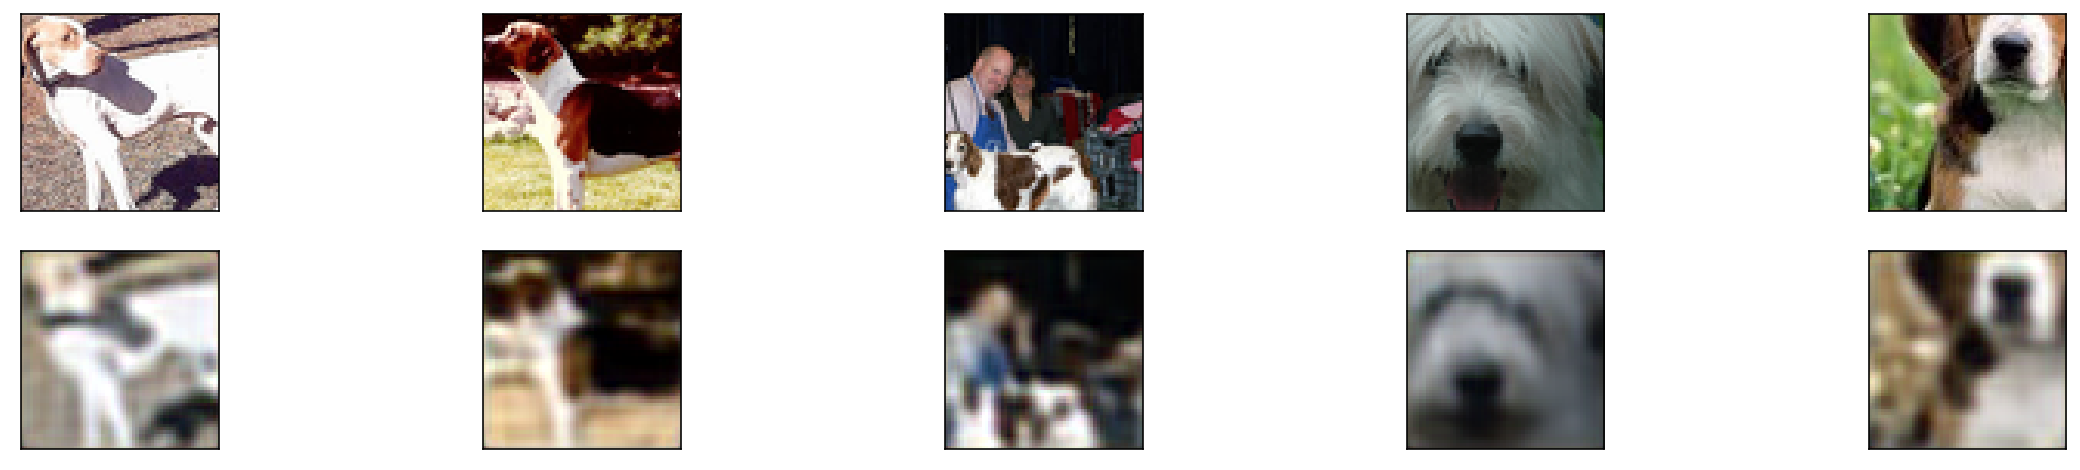

0.44119355


In [155]:
predictions = dog_CAE.predict(x_test)
display(x_test, predictions, x=64, y=64, z=3)
print(np.mean(dog_CAE.predict(x_test)))

Try out 3 more edited models (all with end goal of decreasing MSE):
- Base model while also increasing model complexity through addition of layers(Conv2D and MaxPooling/UpScaling).
- Base model while also adjusting the number of filters for each Conv2D layer.
- Base model while adjusting both factors above - layers and filters.

### Model 2

In [ ]:
# add additional Conv2D and MaxPooling/Upsampling layers on either side
encoder = models.Sequential([layers.Conv2D(64, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=x_train.shape[1:]),
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(64, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(64, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2)])
decoder = models.Sequential([layers.Conv2D(32, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=encoder.output.shape[1:]),
                            layers.UpSampling2D(2),
                            layers.Conv2D(64, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"), 
                            layers.UpSampling2D(2),
                            layers.Conv2D(64, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"),
                            layers.UpSampling2D(2),
                            layers.Conv2D(3, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu")])
dog_CAE = keras.models.Model(inputs=encoder.input, 
                             outputs=decoder(encoder.outputs))
dog_CAE.compile(optimizer="adam", 
                metrics="mse", 
                loss="binary_crossentropy")
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
dog_history = dog_CAE.fit(x_train, x_train, 
                          validation_data=(x_test, x_test), 
                          batch_size=64, 
                          epochs=100,
                          callbacks=[early_stopping])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


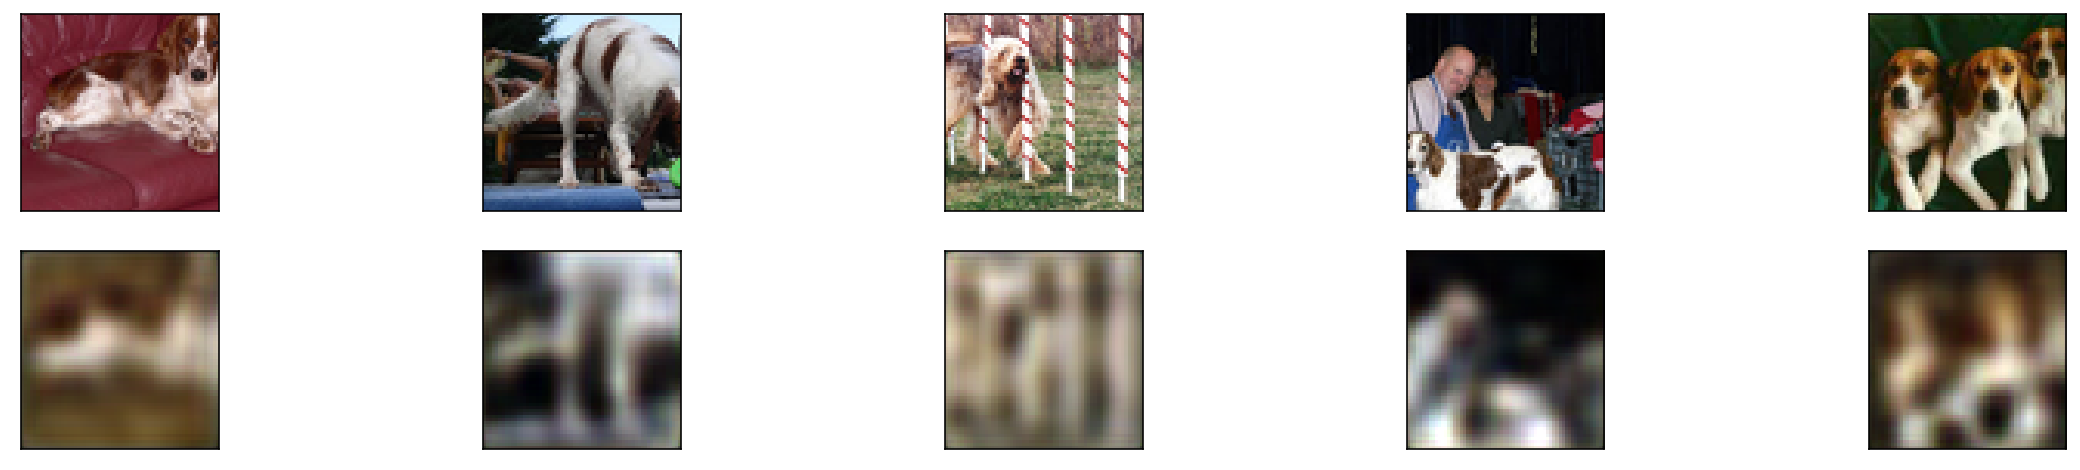

0.4372569


In [157]:
predictions = dog_CAE.predict(x_test)
display(x_test, predictions, x=64, y=64, z=3)
print(np.mean(dog_CAE.predict(x_test)))

### Model 3

In [ ]:
# adjusting filters
encoder = models.Sequential([layers.Conv2D(128, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=x_train.shape[1:]),
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(128, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2)])
decoder = models.Sequential([layers.Conv2D(32, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=encoder.output.shape[1:]),
                            layers.UpSampling2D(2),
                            layers.Conv2D(128, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"),
                            layers.UpSampling2D(2),
                            layers.Conv2D(3, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu")])
dog_CAE = keras.models.Model(inputs=encoder.input, 
                             outputs=decoder(encoder.outputs))
dog_CAE.compile(optimizer="adam", 
                metrics="mse", 
                loss="binary_crossentropy")
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
dog_history = dog_CAE.fit(x_train, x_train, 
                          validation_data=(x_test, x_test), 
                          batch_size=64, 
                          epochs=100,
                          callbacks=[early_stopping])

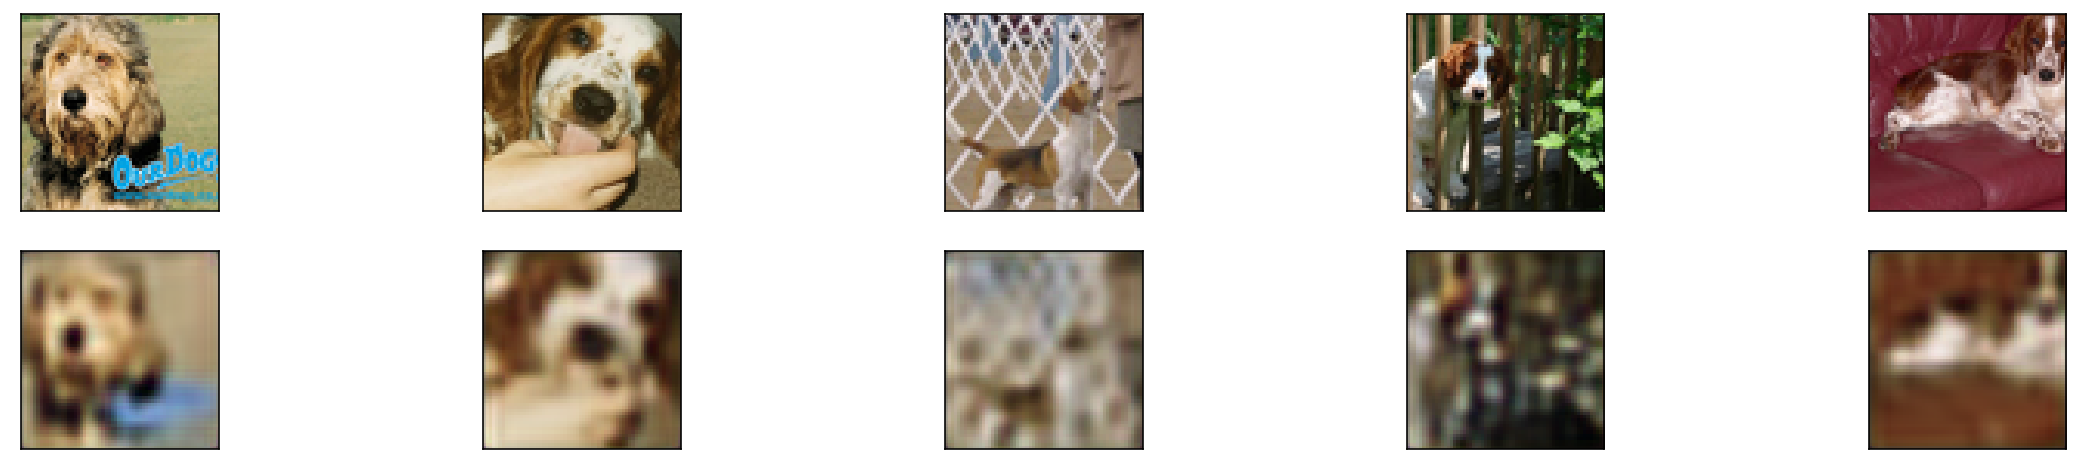

0.43130308


In [159]:
predictions = dog_CAE.predict(x_test)
display(x_test, predictions, x=64, y=64, z=3)
print(np.mean(dog_CAE.predict(x_test)))

### Model 4

In [ ]:
# adjusting layers and filters 
encoder = models.Sequential([layers.Conv2D(128, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=x_train.shape[1:]),
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(128, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2), 
                             layers.Conv2D(128, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu"), 
                             layers.MaxPooling2D(2, strides=2)])
decoder = models.Sequential([layers.Conv2D(32, 3, 
                                           strides=1, 
                                           padding="same", 
                                           activation="relu", 
                                           input_shape=encoder.output.shape[1:]),
                            layers.UpSampling2D(2),
                            layers.Conv2D(128, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"), 
                            layers.UpSampling2D(2),
                            layers.Conv2D(128, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu"),
                            layers.UpSampling2D(2),
                            layers.Conv2D(3, 3, 
                                          strides=1, 
                                          padding="same", 
                                          activation="relu")])
dog_CAE = keras.models.Model(inputs=encoder.input, 
                             outputs=decoder(encoder.outputs))
dog_CAE.compile(optimizer="adam", 
                metrics="mse", 
                loss="binary_crossentropy")
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
dog_history = dog_CAE.fit(x_train, x_train, 
                          validation_data=(x_test, x_test), 
                          batch_size=64, 
                          epochs=100,
                          callbacks=[early_stopping])

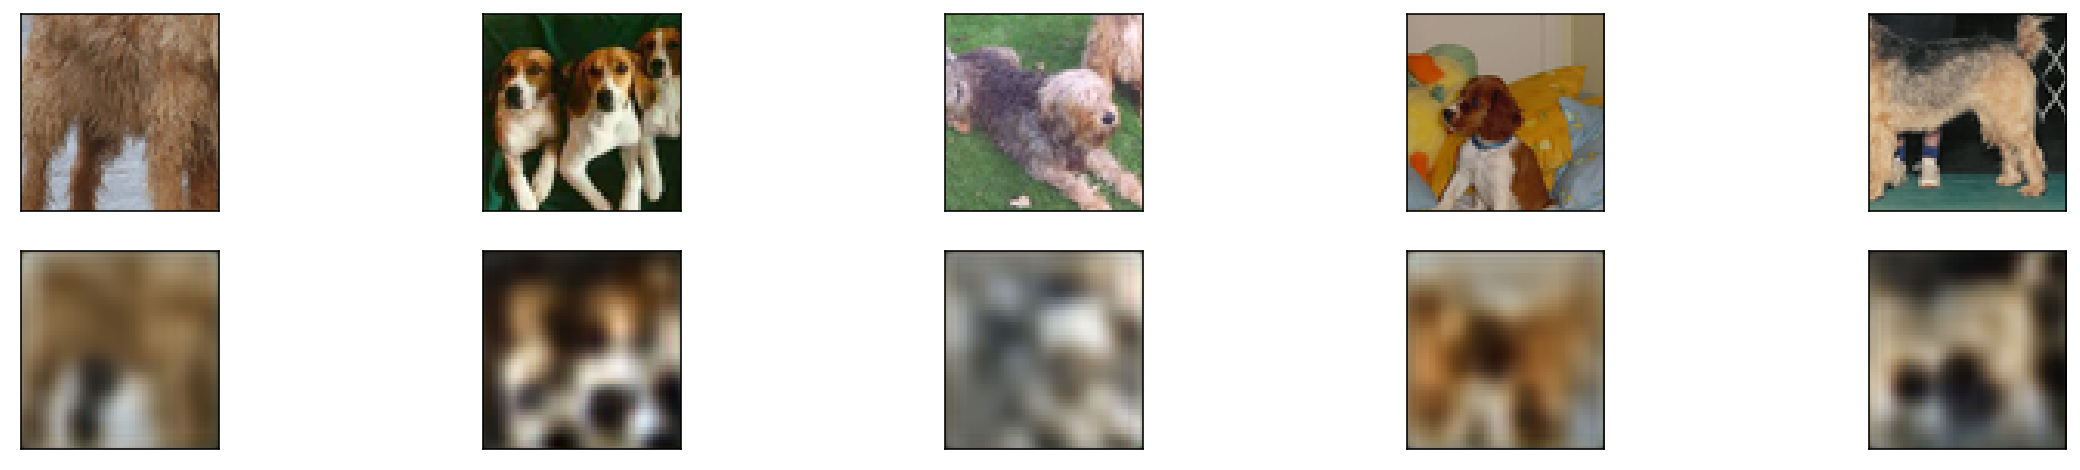

0.43630266


In [161]:
predictions = dog_CAE.predict(x_test)
display(x_test, predictions, x=64, y=64, z=3)
print(np.mean(dog_CAE.predict(x_test)))

## 2 - iii.

Quality of reconstructed images for each model (mean test MSE):
- **Base**: 0.44119355
- **2**: 0.0.4372569 
- **3**: 0.43130308; Comment: Looked best and often had lowest mean test MSE.
- **4**: 0.43630266

# Deep Learning in Natural Language Processing

## i.

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({"id": "1dWCsl8ziZ3KBPb3GzfY0wkRhwV65-4J0"})
download.GetContentFile("x_train_text.csv")
X_train_text = pd.read_csv("x_train_text.csv", header=None)

In [4]:
download = drive.CreateFile({"id": "1M9979h7fdt9Mn62nMiijJAL2-i5UPdIi"})
download.GetContentFile("y_train_text.csv")
y_train_text = pd.read_csv("y_train_text.csv", header=None)

In [5]:
download = drive.CreateFile({"id": "1_ieL52-i7dGeMjSLso0ECwDbiFcZ0Bnj"})
download.GetContentFile("x_test_text.csv")
X_test_text = pd.read_csv("x_test_text.csv", header=None)

In [6]:
download = drive.CreateFile({"id": "1rMXy1hEtoZRKgEJ7rlt8cRcTLcJSQb4n"})
download.GetContentFile("y_test_text.csv")
y_test_text = pd.read_csv("y_test_text.csv", header=None)

In [8]:
X_train = copy.deepcopy(X_train_text).values
y_train = copy.deepcopy(y_train_text).values
X_test = copy.deepcopy(X_test_text).values
y_test = copy.deepcopy(y_test_text).values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25000, 400) (25000, 1) (25000, 400) (25000, 1)


## ii.

In [9]:
# preprocessing
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

In [40]:
model = keras.Sequential([layers.Embedding(5000, 32, input_length=400),  
                          layers.Dropout(0.2),
                          layers.LSTM(100, 
                                      recurrent_dropout=0.2, 
                                      return_sequences=True,
                                      input_shape=(32, )),
                          layers.Dropout(0.2), 
                          layers.LSTM(100, 
                                      recurrent_dropout=0.2, 
                                      return_sequences=True), 
                          layers.Dropout(0.2), 
                          layers.LSTM(100, 
                                      recurrent_dropout=0.2), 
                          layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_accuracy"])
# capture start time
start = time.time()
history = model.fit(X_train_text, y_train_text, 
                    validation_data=(X_test_text, y_test_text), 
                    batch_size=32, 
                    epochs=5)
# capture end time
end = time.time()

Epoch 1/5
782/782 [==============================] - 1943s 2s/step - loss: 0.5695 - binary_accuracy: 0.6977 - val_loss: 0.5082 - val_binary_accuracy: 0.7561
Epoch 2/5
782/782 [==============================] - 1923s 2s/step - loss: 0.4698 - binary_accuracy: 0.7848 - val_loss: 0.4259 - val_binary_accuracy: 0.8084
Epoch 3/5
782/782 [==============================] - 1923s 2s/step - loss: 0.5102 - binary_accuracy: 0.7537 - val_loss: 0.4956 - val_binary_accuracy: 0.7639
Epoch 4/5
782/782 [==============================] - 1920s 2s/step - loss: 0.5678 - binary_accuracy: 0.7052 - val_loss: 0.6366 - val_binary_accuracy: 0.6472
Epoch 5/5
782/782 [==============================] - 1919s 2s/step - loss: 0.4973 - binary_accuracy: 0.7627 - val_loss: 0.4280 - val_binary_accuracy: 0.8098


In [41]:
print(end - start)

9629.251765012741


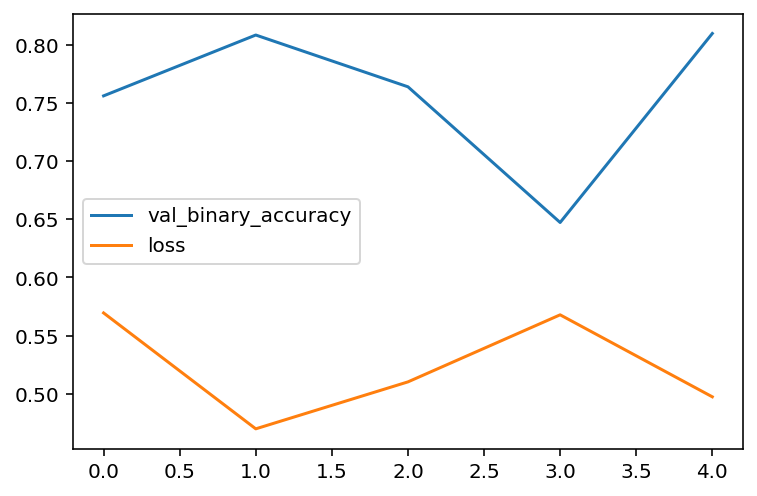

782/782 [==============================] - 219s 280ms/step - loss: 0.4280 - binary_accuracy: 0.8098
Test Accuracy: 80.975997


In [43]:
# plot
plt.plot(history.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.plot(history.history["loss"], label="loss")
plt.legend()
plt.show()

# report test set accuracy
loss, acc = model.evaluate(X_test_text, y_test_text)
print("Test Accuracy: %f" % (acc*100))

Time taken: 9629.251765012741 (s)

## iii.

In [45]:
cnn_model = keras.Sequential([layers.Embedding(5000, 32, input_length=400),
                              layers.Conv1D(32, 8, activation="relu"),
                              layers.MaxPooling1D(2),
                              layers.Flatten(),
                              layers.Dense(10, activation="relu"), 
                              layers.Dense(1, activation="sigmoid")])
cnn_model.compile(optimizer="adam", 
                  loss="binary_crossentropy", 
                  metrics=["binary_accuracy"])
# capture start time
start = time.time()
history_cnn = cnn_model.fit(X_train_text, y_train_text, 
                            validation_data=(X_test_text, y_test_text), 
                            batch_size=32, 
                            epochs=5)
# capture end time
end = time.time()

Epoch 1/5
782/782 [==============================] - 33s 41ms/step - loss: 0.5143 - binary_accuracy: 0.7278 - val_loss: 0.3962 - val_binary_accuracy: 0.8204
Epoch 2/5
782/782 [==============================] - 31s 40ms/step - loss: 0.3842 - binary_accuracy: 0.8306 - val_loss: 0.3809 - val_binary_accuracy: 0.8295
Epoch 3/5
782/782 [==============================] - 31s 40ms/step - loss: 0.3626 - binary_accuracy: 0.8405 - val_loss: 0.3757 - val_binary_accuracy: 0.8329
Epoch 4/5
782/782 [==============================] - 31s 40ms/step - loss: 0.3384 - binary_accuracy: 0.8550 - val_loss: 0.3772 - val_binary_accuracy: 0.8298
Epoch 5/5
782/782 [==============================] - 32s 40ms/step - loss: 0.3050 - binary_accuracy: 0.8720 - val_loss: 0.3865 - val_binary_accuracy: 0.8312


In [46]:
print(end - start)

158.4828917980194


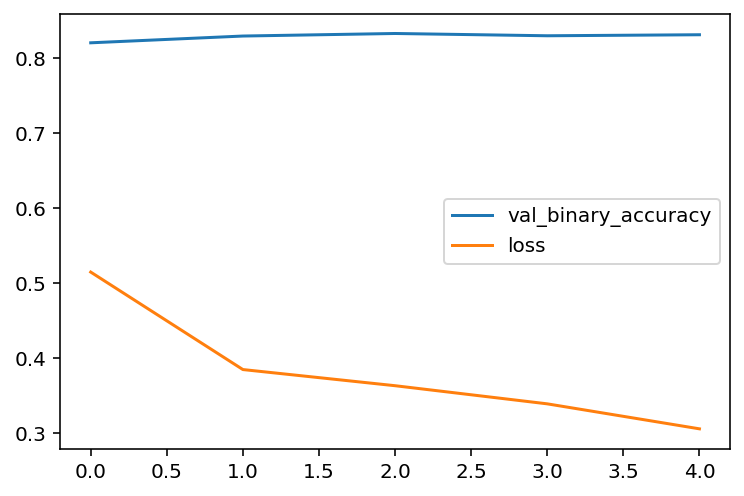

782/782 [==============================] - 6s 8ms/step - loss: 0.3865 - binary_accuracy: 0.8312
Test Accuracy: 83.120000


In [48]:
# plot
plt.plot(history_cnn.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.plot(history_cnn.history["loss"], label="loss")
plt.legend()
plt.show()

# report test set accuracy
loss, acc = cnn_model.evaluate(X_test_text, y_test_text)
print("Test Accuracy: %f" % (acc*100))

Time taken: 158.4828917980194 (s)